# Computer Vision, Assignment 2: Calibration and DLT

In this assignment you will study camera calibration, the projective ambiguity, and the DLT method. 

You will solve the resection and triangulation problems using DLT and compute inner parameters using RQ factorization.
In addition you will try out SIFT for feature detection/matching.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade. All computer exercises not marked **OPTIONAL** are "mandatory" in the sense described on Canvas.

### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).


In [3]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io

from supplied import pflat, plot_camera


# Calibrated vs. Uncalibrated Reconstruction

#### *Theoretical exercise 1* (see pdf)

## Computer Exercise 1
Figure 1 shows an image of a scene and a reconstruction using uncalibrated cameras. The file `compEx1data.mat` contains 
the 3D points of the reconstruction `X`, the camera matrices `P`, the image points `x` and the filenames `imfiles` of the images.
Here `X` is a $4 \times 9471$ matrix containing the homogeneous coordinates for all 3D points, `x{i}` is a $3 \times 9471$ matrix containing the homogeneous coordinates of the image points seen in image $i$ (`NaN` means that the point has not been detected in this image). `P{i}` contains the camera matrix of image $i$ and `imfiles{i}` contains the name of that image.

<figure align="center">
    <img alt="left" src="figs/DSC_0025.JPG" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="figs/projective_rec.png" width="150px">
    <figcaption>Figure 1: Left: An image of the scene. Right: A projective (uncalibrated) reconstruction.</figcaption>
</figure>

### Task 1.1
Plot the 3D points of the reconstruction. Use the supplied function `plot_camera` to plot the cameras in the same figure.

**Do the physical properties (such as the relative heights of each of the two walls, the angle in the corner, and the relation between the width, height, and depth dimensions) look realistic in the reconstruction?**

Don't forget to use `ax.set_aspect('equal')` when plotting -- otherwise you may get additional distortion. The reconstruction should look like the one shown in Figure 1.

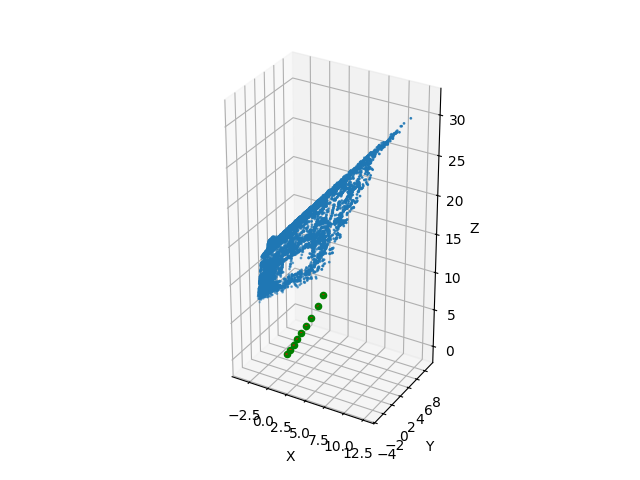

In [4]:

# ------ Your code here ------ 
data = scipy.io.loadmat('data/compEx1data.mat')

X = data['X']
P_list = data['P'][0]

X_flat = pflat(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_flat[0, :], X_flat[1, :], X_flat[2, :], s=1)

for P in P_list:
    plot_camera(P, 0.1, ax)   

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

plt.show()


#### Your answer here: 

(*Include answers to all questions marked in bold.*)
#
The physical properties in the reconstruction do not look completely realistic. We can recognize the two walls and the corner, but the relative heights and dimensions are somewhat distored compared to the image. The corner does not apear perfectly 90 degrees and the relation between width, height and depth looks skretched. This makes sense, since the reconstruction is only projective so angles and metric distances are not preserved. 



### Task 1.2
Project the 3D points into **a camera** of your choice (only points that have been detected in that camera).
Plot the image, the projected points, and the image points in the same figure.

**Do the projections appear to be close to the corresponding image points?** (If not: Did you forget to divide by the third coordinate?)

**Useful python commands:**

`~np.isnan(x_i)` # to check which of the points are visible in image i

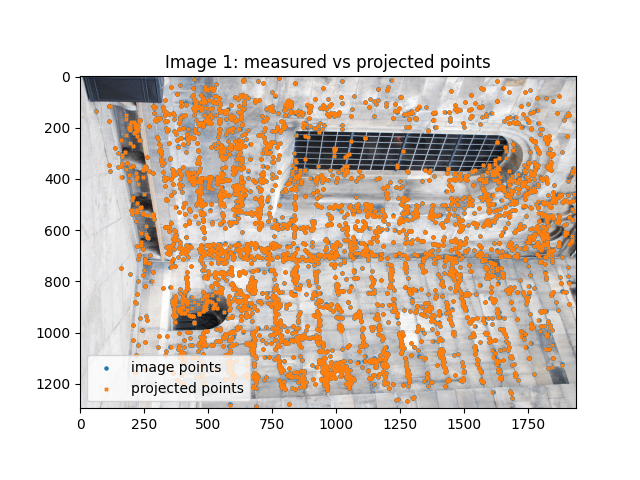

In [5]:

# ------ Your code here ------ 
data   = scipy.io.loadmat('data/compEx1data.mat')
X      = data['X']
P_list = data['P'][0]
x_list = data['x'][0]
imfiles = data['imfiles'][0]

i = 0

P   = P_list[i]
x_i = x_list[i]          

visible = ~np.isnan(x_i[0, :])
X_vis   = X[:, visible]
x_vis   = x_i[:, visible]

x_proj = P @ X_vis
x_proj = pflat(x_proj)   

x_vis_flat = pflat(x_vis)

img_name = imfiles[i][0]          
img = mpimg.imread('data/' + img_name)

plt.figure()
plt.imshow(img)
plt.scatter(x_vis_flat[0, :], x_vis_flat[1, :], s=5, label='image points')
plt.scatter(x_proj[0, :],      x_proj[1, :],      s=5, marker='x', label='projected points')
plt.legend()
plt.title(f'Image {i+1}: measured vs projected points')
plt.show()


#### Your answer here: 

(*Include answers to all questions marked in bold.*)
#
The projections apear to match the image points quite well. When we plot the mtogather, most of the projected points lie almost on top of the detected image points, with only small deviations. This shows that the camera matrices and the 3D reconstruction are consistent. Anys small differences are likely due to noise in the measurements and numerical eroors. 


### Task 1.3
Using the two projective transformations 
\begin{equation}
T_1 = \left( \begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 3 & 0 & 0\\ 
0 & 0 & 1 & 0\\
1/8 & 1/8 & 0 & 1
\end{array} \right) \text{ and }
T_2 = \left( \begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\ 
0 & 0 & 1 & 0\\
1/16 & 1/16 & 0 & 1
\end{array} \right),
\end{equation}

transform the 3D points ($\mathbf{X} \mapsto T_i\mathbf{X}$), and accordingly the cameras (as in *Theoretical Exercise 1*), so that two new projective solutions are obtained.

For each of the solutions, plot the 3D points and cameras in the same figure. (Don't forget to divide the points by the fourth coordinate before plotting, and again don't forget to use `ax.set_aspect('equal')`. Feel free to use the provided `pflat` function.)

**What has happened to the 3D points?**
**Does any of them appear reasonable?**

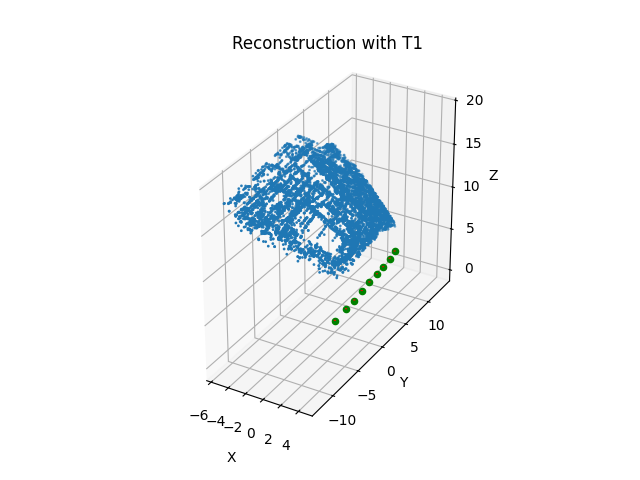

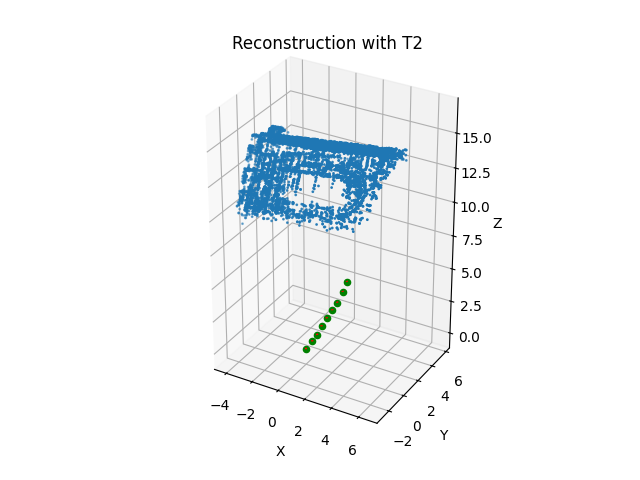

In [6]:

# ------ Your code here ------ 
T1 = np.array([
    [1,   0,   0, 0],
    [0,   3,   0, 0],
    [0,   0,   1, 0],
    [1/8, 1/8, 0, 1]
], dtype=float)

T2 = np.array([
    [1,     0,     0, 0],
    [0,     1,     0, 0],
    [0,     0,     1, 0],
    [1/16,  1/16,  0, 1]
], dtype=float)

X1 = T1 @ X
X2 = T2 @ X

T1_inv = np.linalg.inv(T1)
T2_inv = np.linalg.inv(T2)

P_list_1 = [P @ T1_inv for P in P_list]
P_list_2 = [P @ T2_inv for P in P_list]

def plot_solution(X_trans, P_trans, title):
    X_flat = pflat(X_trans)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X_flat[0, :], X_flat[1, :], X_flat[2, :], s=1)

    for P in P_trans:
        plot_camera(P, 0.1, ax)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.show()

plot_solution(X1, P_list_1, "Reconstruction with T1")
plot_solution(X2, P_list_2, "Reconstruction with T2")


### Your answer here: 

(*Include answers to all questions marked in bold.*)
#
After applying the two projective transformations, the 3D points change shape quite a lot. For T1 the recontruction is skretched and bent and the walls no longer have realistic proportions. With T2 the structure becomes even more warped and almost flattened, so the geometry does not look physically reasonable either. In both cases the image projectins would still fit but the actual 3D shape is very different from the real scene. This illustrates that an uncalibrated reconstruction is only defined up to an arbitrary projective transformation. 


### Task 1.4
For one of the 9 views, and for each of the new reconstructions (resulting from $T_1$ and $T_2$), project the new 3D points into its corresponding transformed camera.
Plot the pair of images along with the corresponding projected points, and the image points in the same figure. 
(Write a function `project_and_plot(P, Xs, xs, image)` that does this for you, it will be useful in the future.)

**How well do the projections and the image points align for the new reconstructions?**

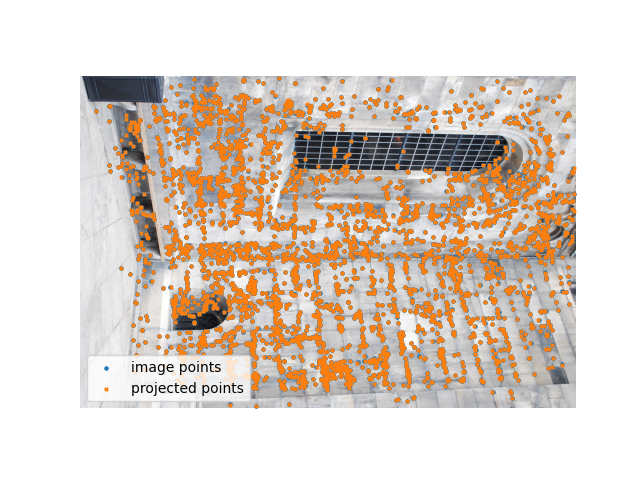

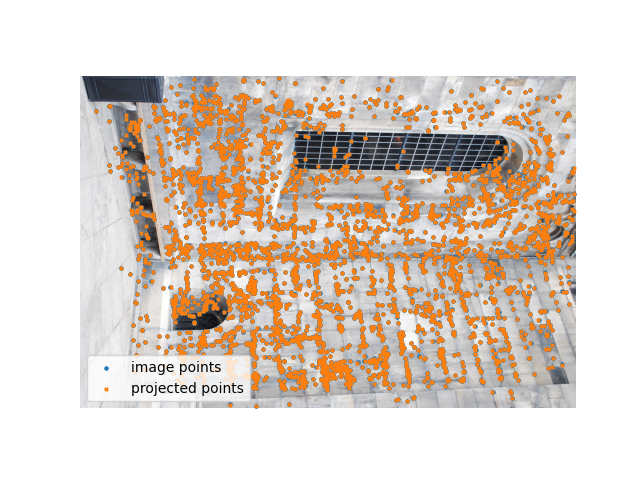

In [7]:
def project_and_plot(P, Xs, xs, image):

    # Your code here
    visible = ~np.isnan(xs[0, :])
    X_vis   = Xs[:, visible]
    x_vis   = xs[:, visible]

    
    x_proj = P @ X_vis
    x_proj = pflat(x_proj)

    x_vis_flat = pflat(x_vis)

    plt.figure()
    plt.imshow(image)
    plt.scatter(x_vis_flat[0, :], x_vis_flat[1, :], s=5, label='image points')
    plt.scatter(x_proj[0, :],     x_proj[1, :],     s=5, marker='x',
                label='projected points')
    plt.legend()
    plt.axis('off')
    plt.show()

data    = scipy.io.loadmat('data/compEx1data.mat')
X       = data['X']
P_list  = data['P'][0]
x_list  = data['x'][0]
imfiles = data['imfiles'][0]

T1 = np.array([
    [1,   0,   0, 0],
    [0,   3,   0, 0],
    [0,   0,   1, 0],
    [1/8, 1/8, 0, 1]
], dtype=float)

T2 = np.array([
    [1,     0,     0, 0],
    [0,     1,     0, 0],
    [0,     0,     1, 0],
    [1/16,  1/16,  0, 1]
], dtype=float)

X1 = T1 @ X
X2 = T2 @ X

T1_inv = np.linalg.inv(T1)
T2_inv = np.linalg.inv(T2)

P_list_1 = [P @ T1_inv for P in P_list]
P_list_2 = [P @ T2_inv for P in P_list]

i = 0
img_i = mpimg.imread('data/' + imfiles[i][0])
# Project and plot the reconstruction resulting from T_1
project_and_plot(P_list_1[i], X1, x_list[i], img_i)


# Project and plot the reconstruction resulting from T_2
project_and_plot(P_list_2[i], X2, x_list[i], img_i)


#### Your answer here: 

(*Include answers to all questions marked in bold.*)
#
For both transformed recontructions with T1 and T2, the projected points still align very well with the detected image points. In the plots, the projected points almost lie on top pf the image points, just like for the orginal reconstruction. So even though the 3 D shape is heavily distored by the projective transformations, the reprojections in the image are essentially unchanged. 

#### *Theoretical exercises: 2* (see pdf)

# Camera Calibration

#### *Theoretical exercises: 3* (see pdf)

# RQ Factorization and Computation of $K$

#### *Theoretical exercises: 4* (see pdf)

# Direct Linear Transformation DLT

#### *Theoretical exercises: 5 and 6* (see pdf)

## Computer Exercise 2
Figure 2 shows two images `cube1.JPG` and `cube2.JPG` of a scene with a Rubik's cube. 
The file `compEx2data.mat` contains a point model `Xmodel` of the visible cube sides, the measured projections `x` of the model points
in the two images and two variables `startind`, `endind` that can be used for plotting lines on the model surface.

<figure align="center">
    <img alt="left" src="figs/cube1.JPG" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="figs/cube2.JPG" width="250px">
    <figcaption>Figure 2: Two images of a scene containing a Rubik's cube.</figcaption>
</figure>

The goal for this exercise is to determine the camera for each of the two views, i.e. resectioning.
*You should consider one view at a time*, i.e. apply your code for each view separately.

### Task 2.1
Normalize the measured points by applying a transformation $N$ that subtracts the mean of the points and then re-scales the coordinates by the standard deviation.
Here, compute mean and standard deviation for $x$ and $y$ separately (separating the coordinates is not crucial, but it helps during grading if you do this in a coherent way).

Plot the normalized points in a new figure. Verify that the points are centered around $(0,0)$ with standard deviation 1 for each of the coordinates.

Remember to print out the mean and standard deviation you used for normalizing x and y, for each camera.

Camera 1 mean (x,y): [1014.85344377  839.03825657]
Camera 1 std  (x,y): [193.93484943 195.82071168]
Camera 2 mean (x,y): [930.9657367  795.18595356]
Camera 2 std  (x,y): [195.71450087 196.72253529]


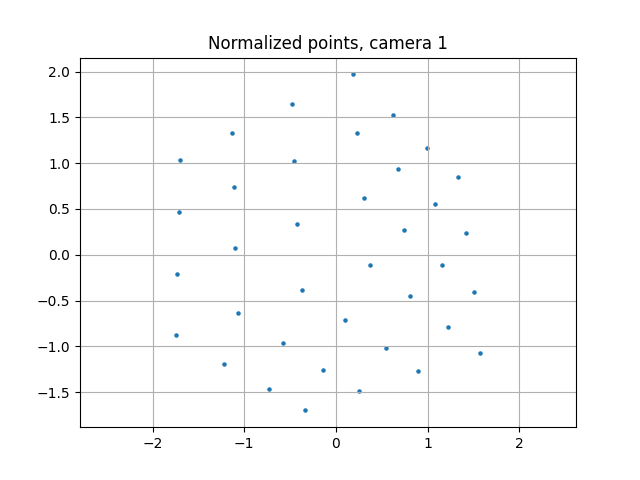

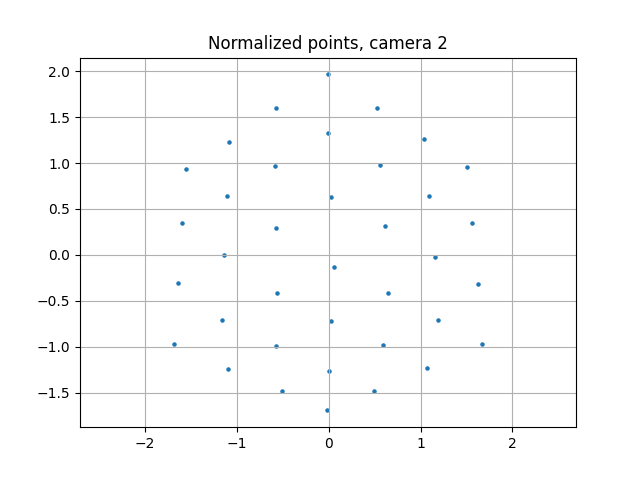

After normalization, camera 1 mean: [-4.44089210e-16  1.32026522e-15]
After normalization, camera 1 std : [1. 1.]
After normalization, camera 2 mean: [ 9.12183242e-16 -2.88057866e-16]
After normalization, camera 2 std : [1. 1.]


In [8]:

# ------ Your code here ------ 

data = scipy.io.loadmat('data/compEx2data.mat')
Xmodel = data['Xmodel']
x_list = data['x'][0]      

def normalize_points(x):
    
    xy = x[:2, :]         

    mean_xy = np.mean(xy, axis=1, keepdims=True)  
    std_xy  = np.std(xy,  axis=1, keepdims=True)  

    N = np.array([
        [1.0 / std_xy[0, 0], 0.0, -mean_xy[0, 0] / std_xy[0, 0]],
        [0.0, 1.0 / std_xy[1, 0], -mean_xy[1, 0] / std_xy[1, 0]],
        [0.0, 0.0, 1.0]
    ])

    if x.shape[0] == 2:
        x_h = np.vstack((x, np.ones((1, x.shape[1]))))
    else:
        x_h = x

    x_norm = N @ x_h      
    return x_norm, N, mean_xy, std_xy

x1 = x_list[0]
x2 = x_list[1]

x1_norm, N1, mean1, std1 = normalize_points(x1)
x2_norm, N2, mean2, std2 = normalize_points(x2)

print("Camera 1 mean (x,y):", mean1.ravel())
print("Camera 1 std  (x,y):", std1.ravel())
print("Camera 2 mean (x,y):", mean2.ravel())
print("Camera 2 std  (x,y):", std2.ravel())

plt.figure()
plt.scatter(x1_norm[0, :], x1_norm[1, :], s=5)
plt.title("Normalized points, camera 1")
plt.axis('equal')
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(x2_norm[0, :], x2_norm[1, :], s=5)
plt.title("Normalized points, camera 2")
plt.axis('equal')
plt.grid(True)
plt.show()

print("After normalization, camera 1 mean:", np.mean(x1_norm[:2, :], axis=1))
print("After normalization, camera 1 std :", np.std(x1_norm[:2, :],  axis=1))
print("After normalization, camera 2 mean:", np.mean(x2_norm[:2, :], axis=1))
print("After normalization, camera 2 std :", np.std(x2_norm[:2, :],  axis=1))



### Task 2.2
Implement a function `estimate_camera_DLT` that sets up the DLT equations for resectioning, and solves the resulting homogeneous least squares system using SVD.

$$\min_{||v||^2 = 1}||Mv||^2$$

**Is the smallest singular value close to zero? How about $||Mv||$?**


**Useful python commands:**

`U, S, Vt = np.linalg.svd(M)` # compute SVD of a matrix

In [9]:
def estimate_camera_DLT(x, Xmodel):
    # Your code here
    if x.shape[0] == 2:
        x_h = np.vstack((x, np.ones((1, x.shape[1]))))
    else:
        x_h = x

    x_h = pflat(x_h)      
    u = x_h[0, :]
    v = x_h[1, :]

    if Xmodel.shape[0] == 3:
        X_h = np.vstack((Xmodel, np.ones((1, Xmodel.shape[1]))))
    else:
        X_h = Xmodel

    N = X_h.shape[1]
    M = np.zeros((2 * N, 12))

    for i in range(N):
        Xw = X_h[:, i]      
        ui = u[i]
        vi = v[i]

        M[2 * i, :]     = np.hstack([Xw, np.zeros(4), -ui * Xw])
        M[2 * i + 1, :] = np.hstack([np.zeros(4), Xw, -vi * Xw])

    U, S, Vt = np.linalg.svd(M)
    v_sol = Vt[-1, :]           
    P = v_sol.reshape(3, 4)

    return P




#### Your answer here: 

(*Include answers to all questions marked in bold.*)
#
The smallest singular value of the DLT matrix \(M\) is much smaller than the other singular values, i.e. it is close to zero but not exactly zero because of noise and modelling errors.  

For the solution vector \(v\) (the last right singular vector), the residual \(\|Mv\|\) is essentially equal to this smallest singular value. Both the smallest singular value and \(\|Mv\|\) are therefore very small, which is exactly what we expect from the homogeneous least–squares formulation used in DLT.

### Task 2.3
Extract the entries of the camera from the solution and set up the camera matrix.
Make sure that you select the solution where the points are in front of the camera.
(If $X$ has 4th coordinate 1 then the 3rd coordinate of $PX$ should be positive for $X$ to be in front of the camera.)

Project the model points into the images. (Don't forget to transform the camera matrix to the original (un-normalized) coordinate system, as in *Theoretiacl Exercise 6*, before projecting.) Plot the measured image points in the same figure. **Are they close to each other?** Also make a 3D plot visualizing the camera centers, principal axes, as well as the 3D model points.
**Does the result look reasonable?**

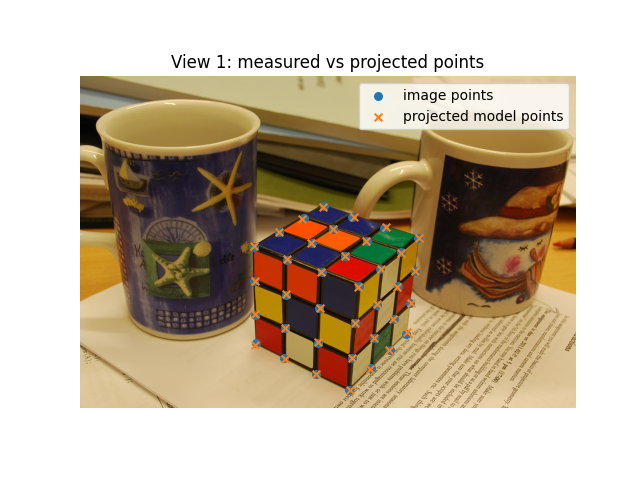

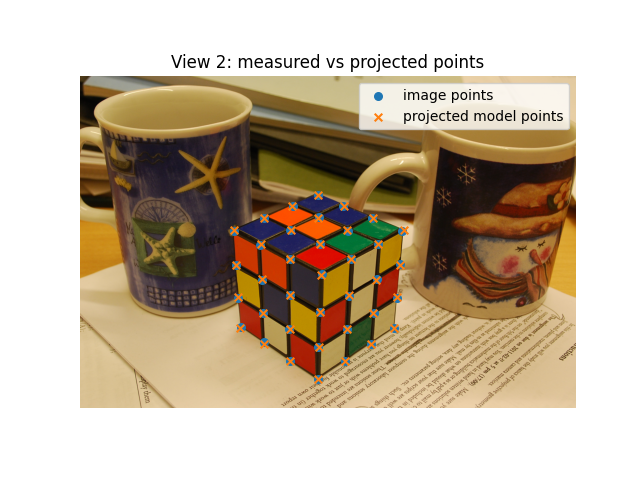

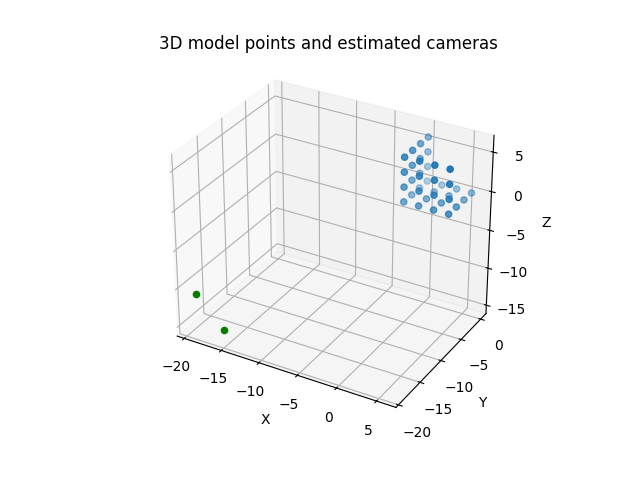

In [10]:

# ------ Your code here ------ 
data    = scipy.io.loadmat('data/compEx2data.mat')
Xmodel  = data['Xmodel']
x_list  = data['x'][0]

x1 = x_list[0]
x2 = x_list[1]

# extract the camera matrices
x1_norm, N1, mean1, std1 = normalize_points(x1)
x2_norm, N2, mean2, std2 = normalize_points(x2)

P1_hat = estimate_camera_DLT(x1_norm, Xmodel)
P2_hat = estimate_camera_DLT(x2_norm, Xmodel)

P1 = np.linalg.inv(N1) @ P1_hat
P2 = np.linalg.inv(N2) @ P2_hat

X_h = np.vstack((Xmodel, np.ones((1, Xmodel.shape[1]))))

if np.mean((P1 @ X_h)[2, :]) < 0:
    P1 = -P1
if np.mean((P2 @ X_h)[2, :]) < 0:
    P2 = -P2


# Project and plot the models points into the images
x1_proj = pflat(P1 @ X_h)
x2_proj = pflat(P2 @ X_h)

x1_flat = pflat(x1)
x2_flat = pflat(x2)

img1 = mpimg.imread('data/cube1.JPG')
img2 = mpimg.imread('data/cube2.JPG')

plt.figure()
plt.imshow(img1)
plt.scatter(x1_flat[0, :], x1_flat[1, :], s=30, label='image points')
plt.scatter(x1_proj[0, :], x1_proj[1, :], s=30, marker='x',
            label='projected model points')
plt.title('View 1: measured vs projected points')
plt.legend()
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(img2)
plt.scatter(x2_flat[0, :], x2_flat[1, :], s=30, label='image points')
plt.scatter(x2_proj[0, :], x2_proj[1, :], s=30, marker='x',
            label='projected model points')
plt.title('View 2: measured vs projected points')
plt.legend()
plt.axis('off')
plt.show()


# Make a 3D plot with 3D model points, camera centers, and principal axes
X_flat = pflat(X_h)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_flat[0, :], X_flat[1, :], X_flat[2, :], s=20)

plot_camera(P1, 0.05, ax)
plot_camera(P2, 0.05, ax)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')
ax.set_title('3D model points and estimated cameras')
plt.show()





### Your answer here: 

(*Include answers to all questions marked in bold.*)
#
The projected model points match the measured image points very well in both views. In the images, the projected points (crosses) almost lie directly on top of the detected points, with only very small deviations. This indicates that the estimated camera matrices are consistent with the data.

In the 3D plot, the two estimated camera centres are located in front of the Rubik’s cube and their principal axes point roughly towards the object. The relative positions of the cameras and the cube also look plausible. Overall, the reprojections and the 3D configuration both look reasonable.



### Task 2.4
Compute the inner parameters of the first camera using RQ decomposition. 

**How can we know that these are the "true" parameters? Why is there no ambiguity as in Theoretical Exercise 1?**

Please also print out the calibration matrix of the first camera, normalized s.t. $K_{33}=1$.

When you have achieved satisfactory results, save the camera matrices (for both views) to be used in further exercises.

**Useful python commands:**

`scipy.linalg.rq(P)` # compute the RQ decomposition of a matrix

In [11]:

# ------ Your code here ------
import scipy.linalg

M1 = P1[:, :3]

K1, R1 = scipy.linalg.rq(M1)

D = np.diag(np.sign(np.diag(K1)))
K1 = K1 @ D
R1 = D @ R1

K1 = K1 / K1[2, 2]

print("Calibration matrix K1 (normalized so that K_33 = 1):")
print(K1)
print("\nRotation matrix R1:")
print(R1)

t1 = np.linalg.inv(K1) @ P1[:, 3]
print("\nTranslation t1:")
print(t1)

np.savez("cube_cameras.npz", P1=P1, P2=P2)
print("\nCamera matrices saved to 'cube_cameras.npz'")

Calibration matrix K1 (normalized so that K_33 = 1):
[[ 2.42183633e+03 -6.77588216e+00  9.80194001e+02]
 [ 0.00000000e+00  2.42003888e+03  6.93975417e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Rotation matrix R1:
[[ 0.55488446 -0.04823084 -0.83052816]
 [-0.37929667  0.87385433 -0.30415893]
 [ 0.74043047  0.48378963  0.46659439]]

Translation t1:
[0.01311866 0.09526975 0.43472476]

Camera matrices saved to 'cube_cameras.npz'


### Your answer here: 

(*Include answers to all questions marked in bold.*)
#
From the RQ decomposition of the left 3×3 part of \(P_1\) I get the calibration matrix \(K_1\) and the rotation matrix \(R_1\). The matrix \(K_1\) is upper triangular, its diagonal entries are positive, and I have normalised it so that \(K_{33} = 1\). This is exactly what we expect for the intrinsic camera matrix. The matrix \(R_1\) is (approximately) orthonormal (\(R_1^T R_1 \approx I\) and \(\det(R_1) \approx 1\)), so it can be interpreted as the orientation of the first camera. The vector \(t_1\) then gives the camera translation.

### Task 2.5 (OPTIONAL, 10 optional points)
You will now re-run your experiments in a few different settings to be compared, investigating the importance of normalization. You only need to do this part for **the first view** (corresponding to 2D points `x{1}`). For each experiment, measure the performance with the RMS error 

$$
\begin{equation}
e_{RMS} = \sqrt{ \frac{1}{n} ||x_{meas} - x_{proj}||_F^2 },
\end{equation}
$$

where $x_{meas}$, $x_{proj}$ are the Cartesian coordinates ($2\times n$-matrices) for the measured points and projected model points respectively, and $n$ is the number of points. Here $|| \cdot ||_F^2$ denotes the (squared) Frobenius norm.

**Useful python commands:**

`np.linalg.norm(dx, 'fro') ** 2` # compute the squared Frobenius norm

In [12]:
def e_rms(x_measured, x_projected):
    # Your code here


SyntaxError: incomplete input (2368780357.py, line 2)

First compute RMS values when using normalization (as you have done so far).
Next, repeat the whole resectioning experiment one more time, but this time don't normalize the points. (The easiest way of doing this is probably to use $N=I$ as normalization matrix and run the same code again.)

**Is the difference large?** 

Report the RMS number and explain your findings.

In [ ]:

# ------ Your code here ------


### Your answer here: 

(*Include answers to all questions marked in bold.*)
#

Now repeat the resectioning experiments (with and without normalization), but this time estimate the camera using only points number $1,4,13,16,25,28,31$. Still, measure the RMS error in a unified way, always using all points!.

**What can you conclude from the experiments that you have run?**

In [ ]:

# ------ Your code here ------



### Your answer here: 

(*Include answers to all questions marked in bold.*)
#

# Feature Extraction and Matching using SIFT

## Computer Exercise 3
In this exercise you will get to try feature extraction using SIFT.

You will need `OpenCV` package for computing SIFT features so first make sure that you have the package installed and successfully imported. 

### Task 3.1
First load the images `cube1.jpg` and `cube2.jpg` from Computer Exercise 2. We will work with **grayscale** images for SIFT.

Compute SIFT features using OpenCV’s implementation of SIFT. 

**Useful python commands:**

`sift = cv2.SIFT_create(contrastThreshold=0.01)` # initialize a sift detector

`keypoints1, descriptors1 = sift.detectAndCompute(im1, None)` # compute keypoints and descriptors


The SIFT detector searches for peaks in scale space (similar to peaks in the autocorrelation function, see lecture notes). The `contrastThreshold` parameter filters out weak peaks.

The variable `keypoints1` contains a list of detected features `kp`. Each keypoint has: 
- `kp.pt` -- $(x, y)$ coordinates
- `kp.angle` -- an orientation
- `kp.size` -- a scale

and the descriptor in `descriptors1` encodes local image information around that point.


In [14]:

# ------ Your code here ------

import os
import cv2
import matplotlib.pyplot as plt

def read_cube_image(name):
    candidates = [
        name,
        os.path.join("data", name),
        name.lower(),
        os.path.join("data", name.lower()),
    ]
    for path in candidates:
        if os.path.exists(path):
            print("Reading:", path)
            return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raise FileNotFoundError(f"Could not find {name} in current folder or in 'data/'")

# load images in greyscale
im1 = read_cube_image("cube1.JPG")
im2 = read_cube_image("cube2.JPG")

print("im1 shape:", im1.shape)
print("im2 shape:", im2.shape)

# compute keypoints and descriptors for both images
sift = cv2.SIFT_create(contrastThreshold=0.01)

keypoints1, descriptors1 = sift.detectAndCompute(im1, None)
keypoints2, descriptors2 = sift.detectAndCompute(im2, None)

print("Number of keypoints in image 1:", len(keypoints1))
print("Number of keypoints in image 2:", len(keypoints2))
print("Descriptor shape image 1:", descriptors1.shape)
print("Descriptor shape image 2:", descriptors2.shape)


Reading: data\cube1.JPG
Reading: data\cube2.JPG
im1 shape: (1296, 1936)
im2 shape: (1296, 1936)
Number of keypoints in image 1: 13147
Number of keypoints in image 2: 14466
Descriptor shape image 1: (13147, 128)
Descriptor shape image 2: (14466, 128)


Visualize the detected keypoints with the images.
```
im1_kp = cv2.drawKeypoints(im1, keypoints1, None,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
```


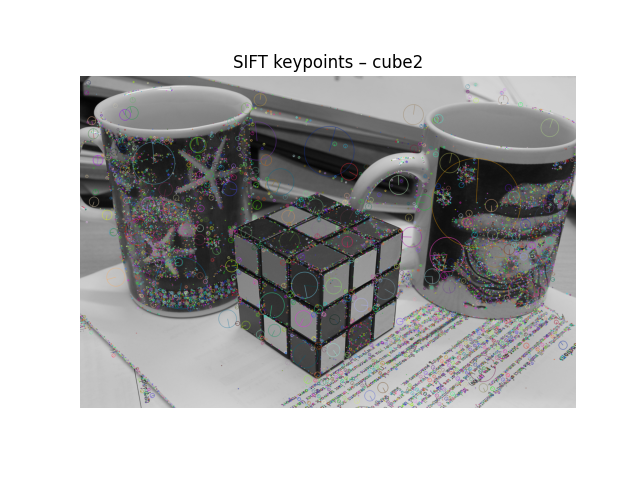

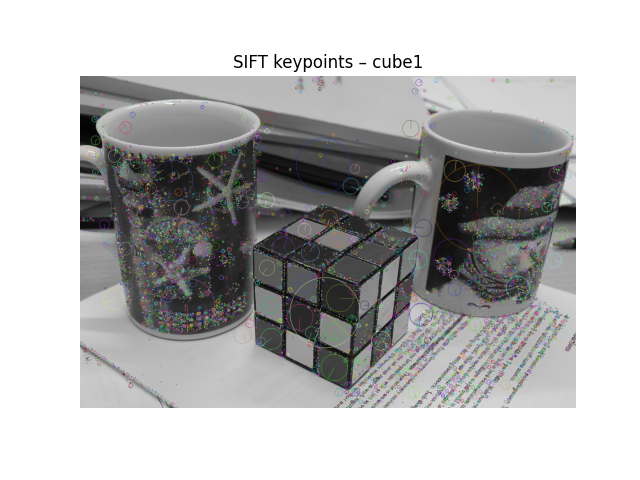

In [23]:

# ------ Your code here ------

im1_kp = cv2.drawKeypoints(
    im1, keypoints1, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
im2_kp = cv2.drawKeypoints(
    im2, keypoints2, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure()
plt.imshow(im1_kp, cmap='gray')
plt.title("SIFT keypoints – cube1")
plt.axis('off')

plt.figure()
plt.imshow(im2_kp, cmap='gray')
plt.title("SIFT keypoints – cube2")
plt.axis('off')

plt.show()




### Task 3.2
We now want to find correspondences between the two sets of SIFT descriptors.

```
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(descriptors1, descriptors2, k=2)
```

For each descriptor in the first image, `bf.knnMatch.knnMatch()` returns `k` best matches in the second image, where `k=2` by default. 

However, sometimes a feature may have two or more similarly good matches, especially in textured or repetitive regions — these are ambiguous and should not be trusted.

We can apply **Lowe's ratio test** to filter out these ambiguous matches by comparing the distance of the best match (`m`) to the second-best match (`n`) and keep only the matches if the best match is much better than the second best (e.g. `m.distance < 0.75 * n.distance`).

Otherwise, both matches are almost equally good, the match is ambiguous, and we should reject it.

In [27]:

## ------ Your code here ------

# Compute matches between descriptors1 and descriptors2
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# k-nearest neighbours (k=2) for varje descriptor i bild 1
matches_knn = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply Lowe's ratio test to filter out the ambiguous matches
good_matches = []
ratio_thresh = 0.75  

for m, n in matches_knn:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

print("Number of knn matches (pairs):", len(matches_knn))
print("Number of good matches after Lowe's ratio test:", len(good_matches))


Number of knn matches (pairs): 13147
Number of good matches after Lowe's ratio test: 2895


### Task 3.3
We can now extract matching points as follows. (Note that you will need the point sets $x1$ and $x2$ for the next exercise.)
```
x1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches]).T
x2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches]).T
```

Randomly select 10 matches, plot the two images next to each other and plots lines between the matching points.

**How many of the matches appear to be correct?**

**Useful python commands:**

```
im_matches = cv2.drawMatchesKnn(im1, keypoints1,
                                im2, keypoints2,
                                selected_matches, None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
```

x1 shape: (2, 2895, 1)
x2 shape: (2, 2895, 1)


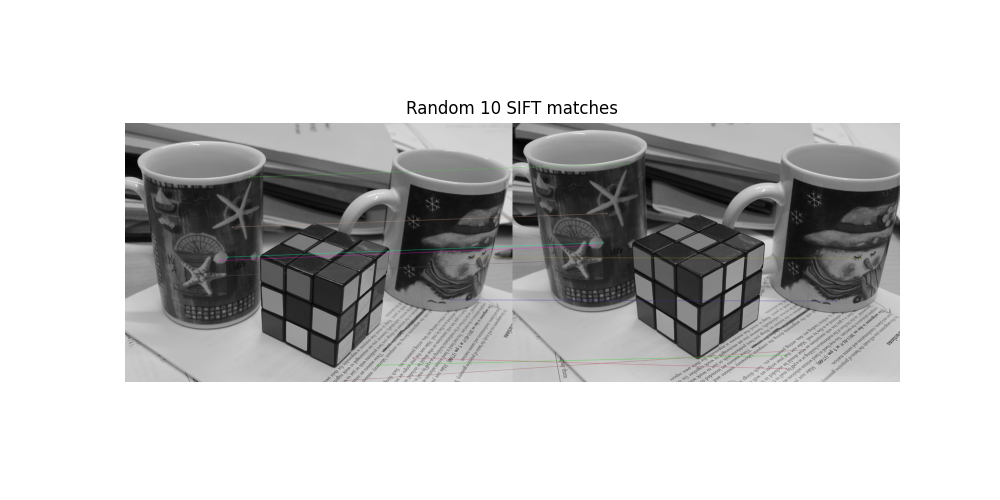

In [30]:
# ------ Your code here ------

import numpy as np

# Extract matching points 
x1 = np.array([[keypoints1[m.queryIdx].pt for m in good_matches]]).T  # 2 x N
x2 = np.array([[keypoints2[m.trainIdx].pt for m in good_matches]]).T  # 2 x N

print("x1 shape:", x1.shape)
print("x2 shape:", x2.shape)

num_to_show = 10
idx = np.random.choice(len(good_matches), size=num_to_show, replace=False)
selected_matches = [[good_matches[i]] for i in idx]  # list of [DMatch] for drawMatchesKnn

# Plot matching points on the two images
im_matches = cv2.drawMatchesKnn(
    im1, keypoints1,
    im2, keypoints2,
    selected_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

im_matches_rgb = cv2.cvtColor(im_matches, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(im_matches_rgb)
plt.title(f"Random {num_to_show} SIFT matches")
plt.axis('off')
plt.show()



### Your answer here: 

(*Include answers to all questions marked in bold.*)
#
From the plot of 10 random SIFT matches, almost all of the matches look correct. The lines connect similar corners/edges of the Rubik’s cube or nearby structures in both images, and I do not see any obvious outliers. I would say that roughly 9–10 out of 10 matches in this sample appear to be correct.


# Triangulation using DLT

## Computer Exercise 4
Using the estimated cameras from Computer Exercise 2 you will now triangulate the points detected in Computer Exercise 3.

### Task 4.1
Implement a function `triangulate_3D_point_DLT` that set ups the DLT equations for triangulation, and solves the homogeneous least squares system.
(You will have to do this in a loop, once for each point.)

In [32]:
def triangulate_3D_point_DLT(x1, x2, P1, P2):
        # Your code here

    x1 = np.asarray(x1).reshape(2,)
    x2 = np.asarray(x2).reshape(2,)

    u1, v1 = x1
    u2, v2 = x2

    A = np.zeros((4, 4))
    A[0, :] = u1 * P1[2, :] - P1[0, :]
    A[1, :] = v1 * P1[2, :] - P1[1, :]
    A[2, :] = u2 * P2[2, :] - P2[0, :]
    A[3, :] = v2 * P2[2, :] - P2[1, :]

    U, S, Vt = np.linalg.svd(A)
    X_h = Vt[-1, :]         

    return X_h              


Project the computed points into the two images and compare with the corresponding SIFT-points in a 2D plot.

X_3D shape: (4, 2895)
x1_proj shape: (3, 2895)
x2_proj shape: (3, 2895)


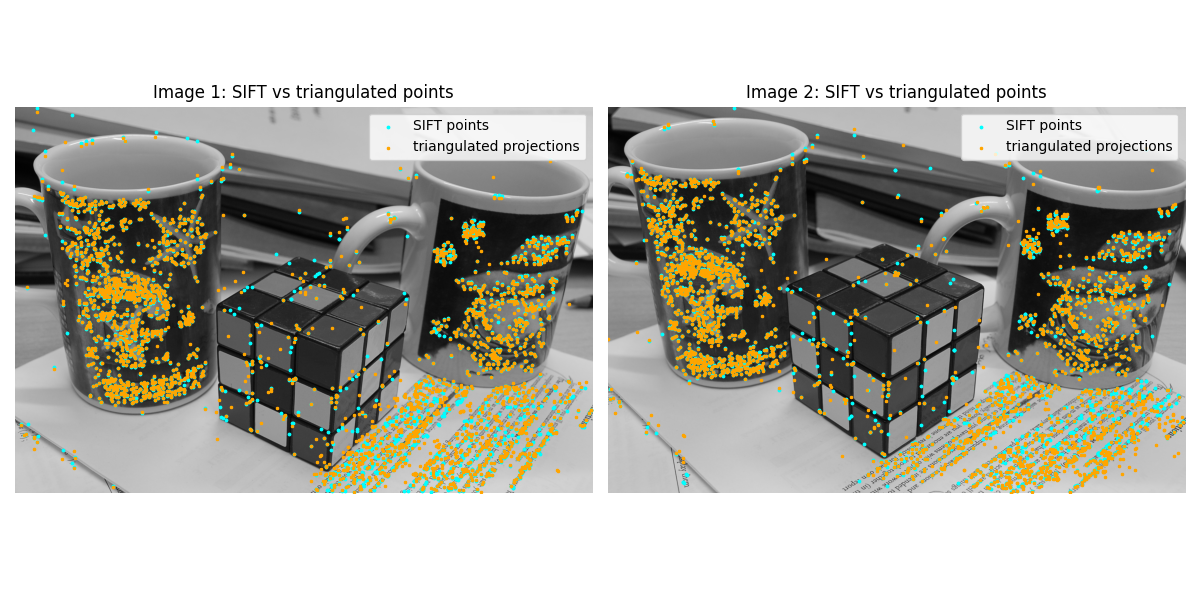

In [39]:
# ------ Your code here ------

# Compute the 3D points

cam_data = np.load("cube_cameras.npz")
P1 = cam_data["P1"]
P2 = cam_data["P2"]

x1_2d = x1.reshape(2, -1)
x2_2d = x2.reshape(2, -1)

N = x1_2d.shape[1]
X_h_all = np.zeros((4, N))

for i in range(N):
    X_h_all[:, i] = triangulate_3D_point_DLT(x1_2d[:, i], x2_2d[:, i], P1, P2)

X_3D = pflat(X_h_all)


# Project the computed points into the two images

x1_proj = pflat(P1 @ X_h_all)   
x2_proj = pflat(P2 @ X_h_all)

print("X_3D shape:", X_3D.shape)
print("x1_proj shape:", x1_proj.shape)
print("x2_proj shape:", x2_proj.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(im1, cmap="gray", origin='upper')
axes[0].scatter(x1_2d[0, :], x1_2d[1, :], s=3, c='cyan', label="SIFT points")
axes[0].scatter(x1_proj[0, :], x1_proj[1, :], s=3, c='orange', marker="x",
                label="triangulated projections")
axes[0].set_title("Image 1: SIFT vs triangulated points")
axes[0].legend()
axes[0].set_xlim([0, im1.shape[1]])
axes[0].set_ylim([im1.shape[0], 0])  
axes[0].axis("off")

axes[1].imshow(im2, cmap="gray", origin='upper')
axes[1].scatter(x2_2d[0, :], x2_2d[1, :], s=3, c='cyan', label="SIFT points")
axes[1].scatter(x2_proj[0, :], x2_proj[1, :], s=3, c='orange', marker="x",
                label="triangulated projections")
axes[1].set_title("Image 2: SIFT vs triangulated points")
axes[1].legend()
axes[1].set_xlim([0, im2.shape[1]])
axes[1].set_ylim([im2.shape[0], 0])
axes[1].axis("off")

plt.tight_layout()
plt.show()



### Task 4.2
Now, re-run the triangulation, but first normalize 2D points and cameras using the inverse of $K$. Again, compare with the SIFT points in a plot.
Just as when normalizing with $N$ (based on mean/std) for the resection problem in Computer Exercise 2, how is your result for triangulation from normalization compared to the result without normalization? Note that using $K$ or $N$ for normalization doesn't matter much, but $K$ was not available for the previous problem (resection).

K1:
 [[ 2.42183633e+03 -6.77588216e+00  9.80194001e+02]
 [ 0.00000000e+00  2.42003888e+03  6.93975417e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
K2:
 [[ 2.39079523e+03 -1.09396992e+01  8.50299885e+02]
 [ 0.00000000e+00  2.40535241e+03  7.70448632e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


ValueError: cannot reshape array of size 3 into shape (2,)

### Task 4.3
From now on, consider only the normalized case.

As we saw in Computer Exercise 3, a portion of the SIFT matches will be incorrect. Most of the time (but not always) this will result in triangulations with large error.
Compute the average pixel error (for each of the two images) between the projected 3D points and the corresponding SIFT points (remember to multiply with $K$ to retrieve pixel coordinates rather than normalized coordinates).

Remove those points for which the error in at least one of the images is larger than $3$ pixels.
Plot the remaining 3D points, the cameras and the cube model in one and the same 3D plot. 

**Can you distinguish the dominant objects (the cups and the paper)?**

In [ ]:

# ------ Your code here ------



### Your answer here: 

(*Include answers to all questions marked in bold.*)
#